In [1]:
import os
import math
import random

import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.convnext import ConvNeXtBase
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

test_local_zip = '/content/drive/MyDrive/Data.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('./')

In [4]:
dataset_dir = "/content/Train"
test_dir = "/content/Test"
classes = ['Plak Gigi', 'Bukan Gambar Gigi', 'Bengkak Gusi', 'Gigi Sehat', 'Gigi Berlubang']

input_size = (224, 224)

batch_size = 32

# Create data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7, 1.3],
    channel_shift_range=10,
    validation_split=0.2
)

train_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    classes=classes
)

validation_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    classes=classes,
    shuffle=False
)

test_data_gen = ImageDataGenerator(rescale = 1./255)
test_ds = test_data_gen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    classes=classes,
    shuffle=False
)

Found 685 images belonging to 5 classes.
Found 168 images belonging to 5 classes.
Found 214 images belonging to 5 classes.


Random Samples from Train Dataset:


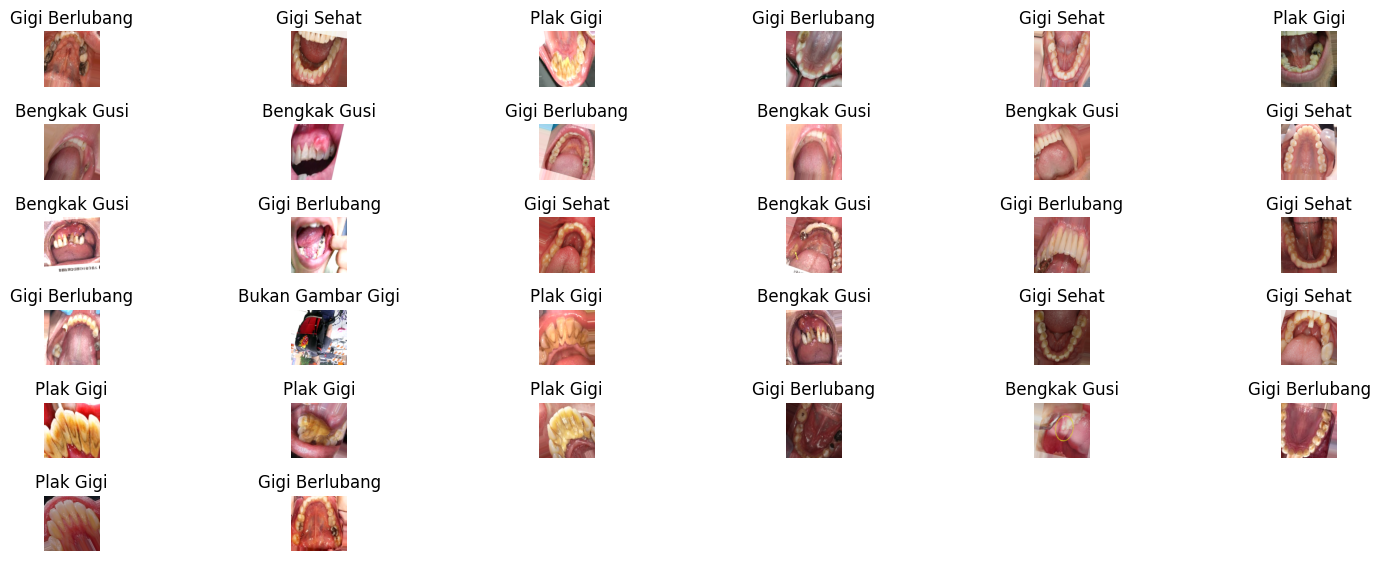

Random Samples from Validation Dataset:


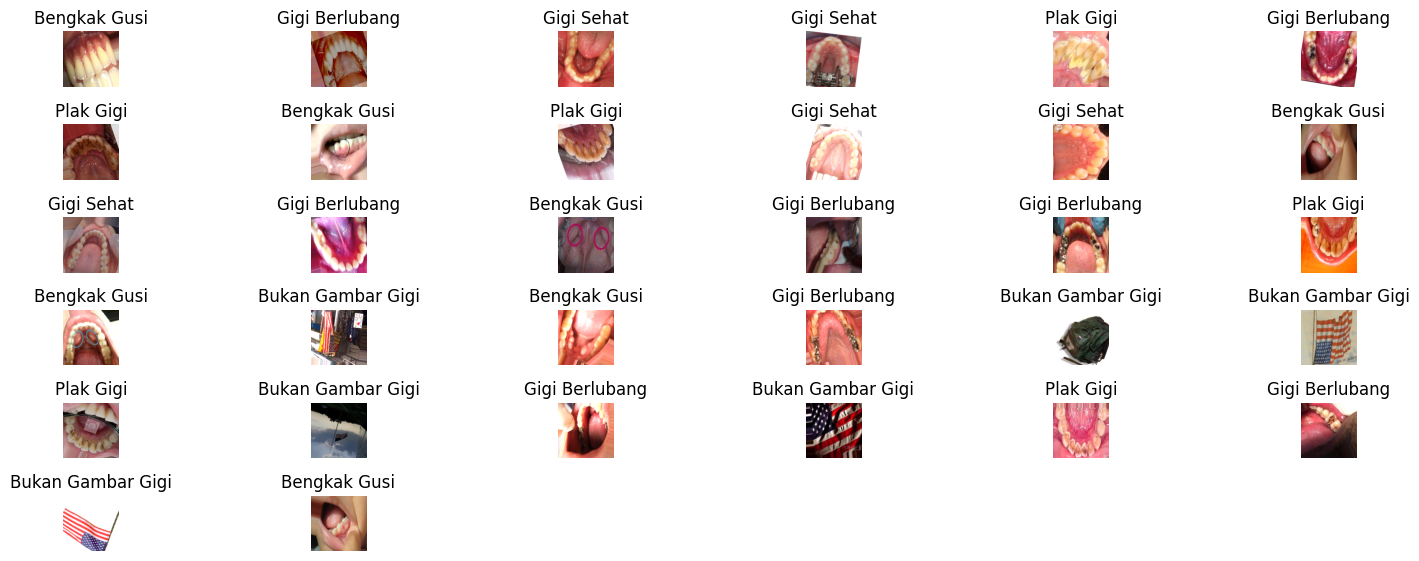

Random Samples from Test Dataset:


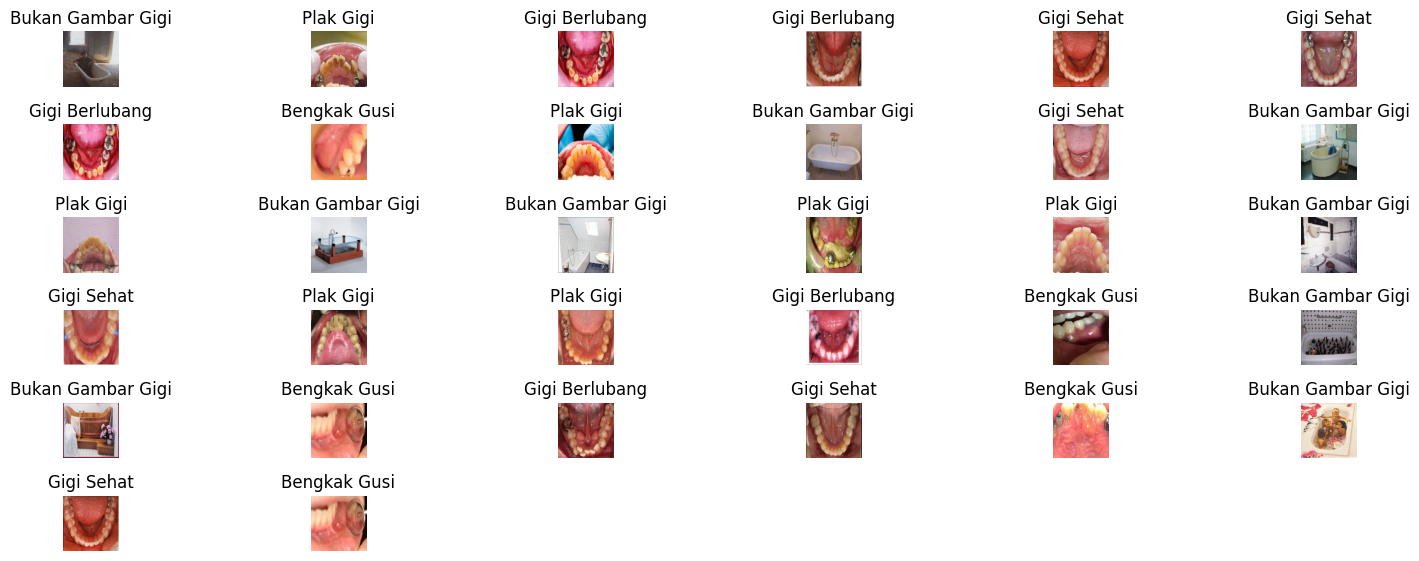

In [5]:
def display_random_samples(data_generator, num_samples=96):
    num_cols = 6
    num_rows = math.ceil(num_samples / num_cols)
    plt.figure(figsize=(15, 15))

    # Shuffle the data generator
    data_generator.shuffle = True

    for i, (X_batch, y_batch) in enumerate(data_generator):
        for j in range(min(num_samples, len(X_batch))):
            plt.subplot(num_rows, num_cols, j+1)
            plt.imshow(X_batch[j])
            plt.title(f"{list(data_generator.class_indices.keys())[int(y_batch[j])]}")
            plt.axis("off")
        if i >= (num_samples / batch_size) - 1:
            break  # Stop after displaying the required number of samples
    plt.tight_layout()
    plt.show()

# Display random samples from train dataset
print("Random Samples from Train Dataset:")
display_random_samples(train_ds)

# Display random samples from validation dataset
print("Random Samples from Validation Dataset:")
display_random_samples(validation_ds)

# Display random samples from test dataset
print("Random Samples from Test Dataset:")
display_random_samples(test_ds)

In [6]:
train_class_labels = list(train_ds.class_indices.keys())
train_class_labels

['Plak Gigi',
 'Bukan Gambar Gigi',
 'Bengkak Gusi',
 'Gigi Sehat',
 'Gigi Berlubang']

In [7]:
num_classes = len(train_class_labels)
num_classes

5

In [8]:
base_model = ConvNeXtBase(
    model_name='convnext_base',
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=8,
    classifier_activation='softmax'
)

# Freeze layers up to a certain point
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last four layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Create a new model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

350926856/350926856 [==============================] - 9s 0us/step


In [9]:
initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [11]:
from sklearn.utils.class_weight import compute_class_weight

true_labels = validation_ds.classes
class_indices = np.unique(true_labels)

class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(true_labels),
    y = true_labels)
class_weights = dict(enumerate(class_weights))

In [12]:
epochs = 50
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Epoch 1/50
22/22 [==============================] - 61s 2s/step - loss: 1.9559 - accuracy: 0.1956 - val_loss: 1.6908 - val_accuracy: 0.2024
Epoch 2/50
22/22 [==============================] - 21s 916ms/step - loss: 1.9646 - accuracy: 0.1737 - val_loss: 1.6692 - val_accuracy: 0.2024
Epoch 3/50
22/22 [==============================] - 20s 899ms/step - loss: 1.8863 - accuracy: 0.2161 - val_loss: 1.6588 - val_accuracy: 0.2024
Epoch 4/50
22/22 [==============================] - 35s 2s/step - loss: 1.8659 - accuracy: 0.1912 - val_loss: 1.6512 - val_accuracy: 0.1845
Epoch 5/50
22/22 [==============================] - 20s 903ms/step - loss: 1.8631 - accuracy: 0.2000 - val_loss: 1.6406 - val_accuracy: 0.2738
Epoch 6/50
22/22 [==============================] - 31s 1s/step - loss: 1.8580 - accuracy: 0.1825 - val_loss: 1.6374 - val_accuracy: 0.2679
Epoch 7/50
22/22 [==============================] - 26s 1s/step - loss: 1.8168 - accuracy: 0.2058 - val_loss: 1.6386 - val_accuracy: 0.2679
Epoch 8/50


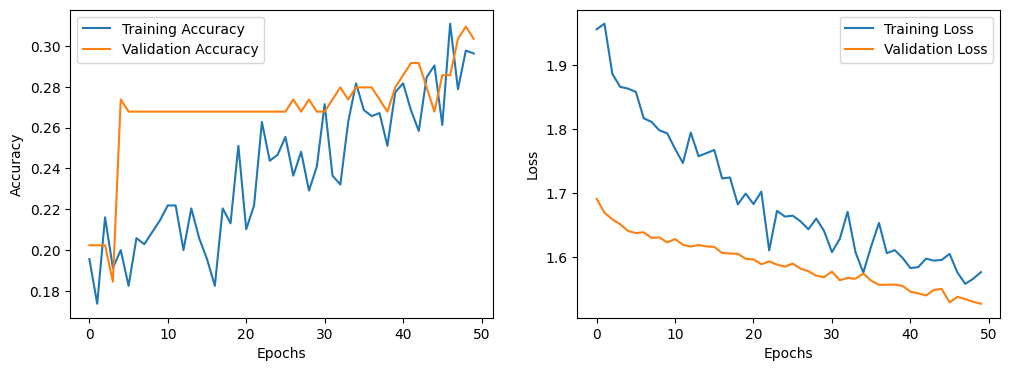

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Testing**

In [15]:
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_ds.classes

print(classification_report(true_labels, predicted_labels))

7/7 [==============================] - 8s 1s/step
              precision    recall  f1-score   support

           0       0.27      0.90      0.42        58
           1       0.19      0.07      0.10        43
           2       0.00      0.00      0.00        32
           3       0.25      0.02      0.04        43
           4       0.00      0.00      0.00        38

    accuracy                           0.26       214
   macro avg       0.14      0.20      0.11       214
weighted avg       0.16      0.26      0.14       214



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|    | Nama   |   Akurasi |
|---:|:-------|-------:|
|  1 | Train   |     0.2964 |
|  2 | Validation  |     0.3036 |
|  3 | Test    |     0.26 |

In [ ]:
model.save("TampakBawah_ConvNeXt_FineTuned.h5")